# Research Bias Mitigation with GloVe and BERT embeddings

Team: Alex Shockley, Will Landin, Rick Lattin
Repo: https://github.com/lattiric/ML_NN_Proj_01

## Overview

In this notebook, we will look at several different configurations of datasets, models, and embeddings to determine if any of the embedding/model combinations appear to show more racial bias than others. We will start by training 3 different model architectures on 2 different datasets using 2 different embeddings to classify sentences/words as positive or negative (Sentiment analysis). Once we have the models trained, we will look at a curated set of names and throw sentences such as "Hello, my name is (Name)" to see if there is a significant difference between the perceived sentiment scores of the sentences.


It is extremely important to find this type of bias in machine learning models, as these types of models are being used more and more frequently, and with the emergence of ChatGPT, they are being used as a source of factual information more and more frequently as well. Granted that ChatGPT is a large language model that is not exactly the same as what we are working with here, the prediction models we are implementing here serve as a small-scale example of how racial bias can be easily and unintentionally added to machine learning and AI models during training if we are not careful. On a larger scale, this could result in the perpetuation and strengthening of pre-existing biases in people as they turn to machine learning and AI models for information about the world around them. The study of which part of the ML model truly holds most of the racial bias is imperative to creating and providing people with ML models that have the least amount of racial bias possible.

##### Research Questions:
How can we best mitigate bias seen in word embeddings? Where do the biases come from, is it a dataset problem? What about the complexity of the model, does using a more complex Neural Network help the problem? Is it the embedding itself? Below are our hypotheses we have and research questions we have in the hopes of answering these broad questions.


#### Hypotheses:
- **Due to BERT's inherent design philosophy of incorporating context into itself we believe BERT will do the best job of mitigating bias and will be performing better than the GLOVE embedding we saw in class.**
   - To test this we will use three levels of models(going into more detail below) to see how well it will do across different model complexities. To measure its performance we will be comparing our BERT models against the GLOVE counterparts. In our effort to make it a fair comparison, we will perform PCA on BERT to get it to be a size 300 embedding (the same size as GLOVE)
   - We will be using the sentiment140 tweets dataset(more details below) to train the models and will compare it to positive and negative word list lexicon (single word dataset we used in class) to see these models being used in different contexts to make a more fair comparison.
- **We believe context is key when mitigating bias, so we will be having experiments that we think will be adding and removing levels of context to see how different combinations of embedding models and datasets will perform.**
   - We believe that a CNN will bring much-needed context to the GLOVE embedding and will have at least comparable results to the BERT embedding counterpart
       - We saw in class that a combination of the GLOVE embedding (no inherent context) and a single-word dataset(words with no context) led to showing bias between racial groups. By incorporating the power of a sentence dataset(words with context) with a CNN (a model with slight levels of context) we hope to mitigate the bias we found in the glove

### Datasets that we will use
We will be leveraging two different datasets. The first is one from Kaggle that has sentiment scores as either positive or negative that was curated from Twitter (this dataset is at the sentence level https://www.kaggle.com/datasets/kazanova/sentiment140/discussion/454347). The second dataset is the one that we utilized in class and is labeled at an individual word level (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon). We chose to use two different datasets in order to get a fair comparison between the different embeddings. We will be using a similar technique that we saw in class, taking the sentiment for each word in a sentence and averaging the sentiment score across it, as well as concatenating the embedding vectors for a sentence together, running PCA on it to reduce down to 300 dimensions and classifying at the sentence level. This was necessary because BERT was designed to take into the entire context of a sentence, not just a single word at a time. We hypothesize that the BERT embeddings will be significantly better at the sentence level compared to GLOVE, but we are interested in seeing how BERT will perform in the word-level classification with an average sentiment value.


### Models that we will use
We will be leveraging 3 different classifier architectures to feed the BERT and GLOVE embeddings for sentiment analysis to see if one of the model architectures further contributes to an inherent bias. The model architectures that we will use will be as follows:
- A simple deep neural network (1 64-neuron dense layer, a dropout layer, and a single neuron layer to output the sentiment score)
- A simple Logistic Regression classifier
- A convolutional neural net (1 1D 128 neuron convolution layer, a max pooling layer, a dropout layer, a flattened layer, 1 64 neurons dense layer, and a single neuron layer to output sentiment score)


Both of the functions that generate the neural network models (the deep neural network and the CNN) are located in the `helpers.py file`, as `generateSimpleDenseNetwork` and `generateCNN`.



### Embeddings that we will use
We will be leveraging both the glove.840B.300d and a BERT embedding.
#### GLOVE
The glove embedding is just a simple download and lookup table in order to extract the vector for a single word. When we are using GLOVE with a sentence, we took two approaches. Firstly, we took the embedding for each word, classified each word with a sentiment score, and then averaged across the sentence. The second approach to getting a sentiment score for a sentence was to concatenate the vectors of each word in the sentence, and then run a PCA decomposition on those vectors to get back into a 300-dimensional vector. (The vectors that were not the length of the max length were padded with 0 vectors to meet the max length) ie. `[[0.4, 0.3, 0.2, 0.6],[0.1, 0.1]]` -> `[[0.4, 0.3, 0.2],[0.1, 0.1, 0.0, 0.0]]`
#### BERT
The second embedding that we wanted to look at was a BERT embedding. This was a bit more complicated to obtain than the lookup table of GLoVe. We feed each sentence(or word if we are doing the word-based approach) into BERT and steal the last hidden layer for that sentence. Once we have that vector (768 dimensions), we run a PCA decomposition in order to compress it down to 300 dimensions so that we can feed these embeddings into the same classifiers.


__NOTE:__ The PCA decomposition was fit to ONLY the training set and was used to transform the test and validation sets used in training in order to avoid cross-contamination between the training testing and validation sets. Nonetheless, the use of PCA in both cases slightly alters the outputs of the models and possibly alters the biases. Unfortunately, this dimensionality reduction is necessary in the case of our project, so we are going to attempt to find biases despite the influence of PCA.




## Code

### Data preparation
In this section, we grab the two datasets and label them `sentence_df` and `word_df` for the tweet dataset and the sentiment lexicon from class respectivley. We also create the Generator object that is responsible for getting different embeddings given a dataframe and splitting them into train, test, and validation sets. See `embeddings.py` for the implementation of this class.

In [1]:
from embeddings import EmbeddingGenerator
import helpers
import pandas as pd
import numpy as np
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn
from sklearn.linear_model import SGDClassifier
import os
os.environ["tf_gpu_allocator"]="cuda_malloc_async"

gen = EmbeddingGenerator(only_bert=False,cached_embedding_path = '../../data/concept_net/cached_embeddings') # Creating a Generator object that handles all of the embedding conversions

sentence_df = helpers.pre_process_input_data(filepath='../../data/concept_net/tweets.csv',num_samples=20000) # Getting the data from the tweet dataset
pos_words = helpers.load_lexicon('../../data/concept_net/positive-words.txt')
neg_words = helpers.load_lexicon('../../data/concept_net/negative-words.txt')
word_df = pd.concat([ #Convert pos and neg words into single dataframe with labels
    pd.DataFrame({'word':pos_words,'target':[1] * len(pos_words)}),
    pd.DataFrame({'word':neg_words,'target':[0] * len(neg_words)})
])

del pos_words #Clear up ram because god knows this project eats a lot of it 
del neg_words

2024-02-10 11:05:25.046226: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 11:05:25.046264: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 11:05:25.046277: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS

<Axes: >

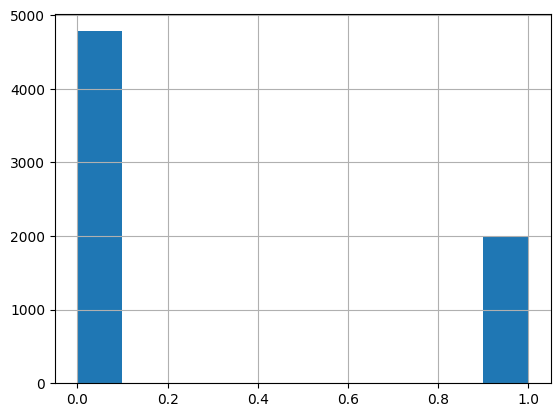

In [2]:
word_df['target'].hist()

The distribution of the positive classified words and the negative classified words in the single word sentiment analysis lexicon.

<Axes: >

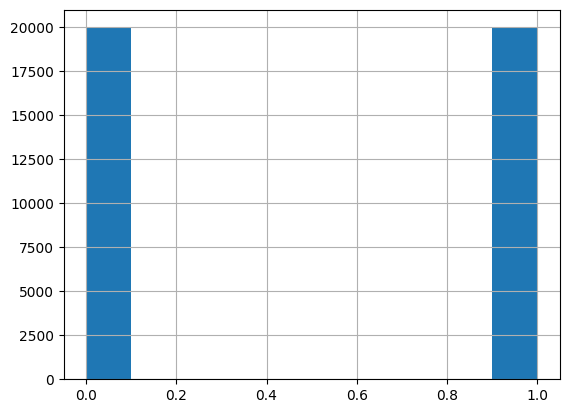

In [3]:
sentence_df['target'].hist()

The distribution of the positive classified sentences and the negative classified sentences in a sample of the tweet sentiment analysis dataset.

## Models
As previously mentioned we have implemented 3 different model structures in this notebook. These structures consist of a simple neural network, a logistic regression model, and a convolutional neural network.


- The simple neural network is a sequential model that essentially functions as a two-layer perceptron. It is comprised of an input layer two dense layers, and a dropout layer.


- The logistic regression model uses stochastic gradient descent to make its predictions.


- Finally, the convolutional neural network is comprised of a 1-dimensional convolution layer, a max pooling layer, and a dropout layer. This is followed by a flattening layer and two dense layers to complete the model.


Both the simple NN and CNN implement callbacks and use Adam as the optimizer for the model. Furthermore, all of the models listed above take in an input vector that is 300 rows by 1 column. This sizing for the input vector was determined based off of the sizing for the glove embeddings, which was 300 by 1 as well. This forced us to perform dimensionality reduction through PCA on the BERT model and parts of the glove embeddings, which is detailed earlier in the notebook.


In [4]:
simple_dense = helpers.generatSimpleDenseNetwork(return_callbacks=False)

In [5]:
plot_model(simple_dense)
del simple_dense

## Sentiment Training

In this section we run data obtained from the tweets dataset, and pass it through the Bert and Glove embeddings. We add respective embedding values to each data point to create the testing and training data used for all the sentence based prediction tasks throughout the notebook.

In [6]:
bert_train_features, bert_test_features, bert_val_features,\
    bert_train_labels, bert_test_labels, bert_val_labels, \
    bert_train_text, bert_test_text, bert_val_text = gen.get_train_test_val_with_bert(sentence_df,test_size=0.2)

glove_train_features, glove_test_features, glove_val_features, \
    glove_train_labels, glove_test_labels, glove_val_labels, \
    glove_train_text, glove_test_text, glove_val_text = gen.get_train_test_val_with_other_embedding_multi_word(sentence_df,test_size=0.2)


Grabbing BERT Embeddings with padding to 282 characters


  0%|          | 0/80 [00:00<?, ?it/s]

Converting multi word text into Other Embedding (Glove by default)


  0%|          | 0/40000 [00:00<?, ?it/s]

Removing 170 entries that did not exist in embeddings
Max feature vec size: 10200


In [7]:
print(f"""
Bert Train Vector Shape: {bert_train_features.shape}
Bert Validation Vector Shape: {bert_val_features.shape}
Bert Test Vector Shape: {bert_test_features.shape}
"""
     )
print(f"""
Glove Train Vector Shape: {glove_train_features.shape}
Glove Validation Vector Shape: {glove_val_features.shape}
Glove Test Vector Shape: {glove_test_features.shape}
"""
     )


Bert Train Vector Shape: (25600, 300)
Bert Validation Vector Shape: (6400, 300)
Bert Test Vector Shape: (8000, 300)


Glove Train Vector Shape: (25491, 300)
Glove Validation Vector Shape: (6373, 300)
Glove Test Vector Shape: (7966, 300)



### Sentence Level training

#### Simple dense network predictor

In [8]:
bert_simple_dense, bert_callbacks = helpers.generatSimpleDenseNetwork()
glove_simple_dense, glove_callbacks = helpers.generatSimpleDenseNetwork()
bert_result = bert_simple_dense.fit(bert_train_features,bert_train_labels,epochs=200,validation_data=(bert_val_features,bert_val_labels),callbacks=bert_callbacks,verbose=0)
glove_result = glove_simple_dense.fit(glove_train_features,glove_train_labels,epochs=200,validation_data=(glove_val_features,glove_val_labels),callbacks=glove_callbacks,verbose=0)

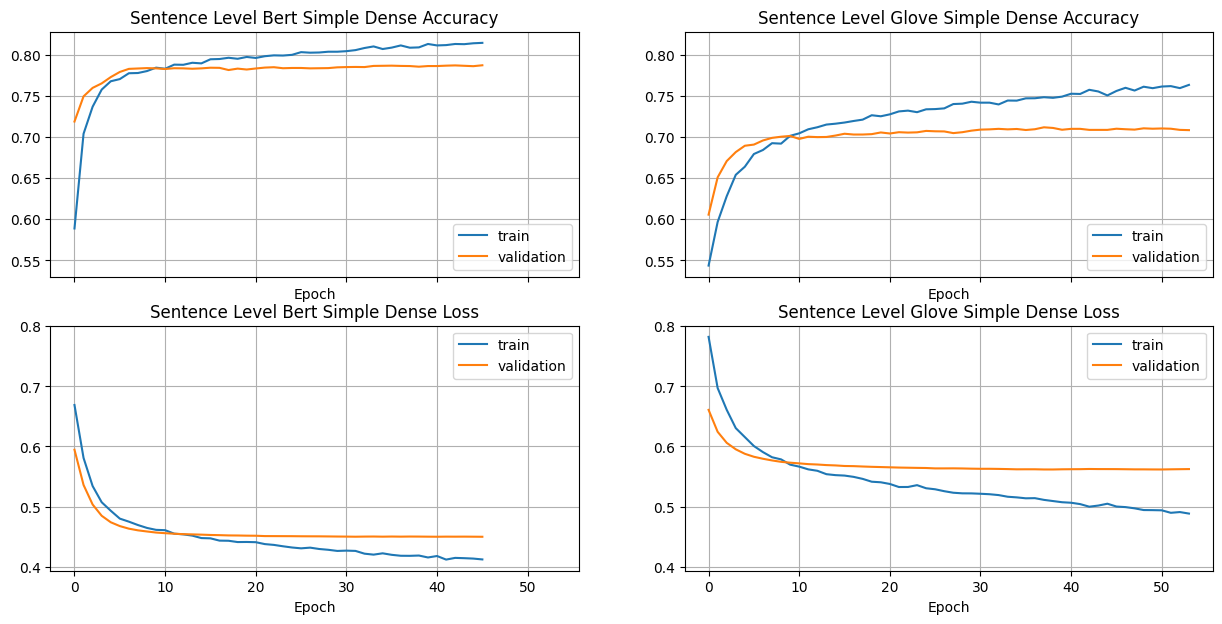

In [9]:

helpers.plot_model_stats(bert_result,glove_result,mdl1_name='Sentence Level Bert Simple Dense',mdl2_name='Sentence Level Glove Simple Dense')

As can be seen through the graphs, after training off of full sentences the simple dense neural network appears to converge when given both the Bert and Glove applied data. Furthermore, the graphs show no signs of overfitting within the model.

In [10]:
bert_test_df = pd.DataFrame({
    'target':bert_test_labels,
    'text': bert_test_text,
    'predict': bert_simple_dense.predict(bert_test_features).flatten()
})

glove_test_df = pd.DataFrame({
    'target':glove_test_labels,
    'text': glove_test_text,
    'predict': glove_simple_dense.predict(glove_test_features).flatten()
})

bert_test_df['diff'] = bert_test_df['target'] - bert_test_df['predict']
glove_test_df['diff'] = glove_test_df['target'] - glove_test_df['predict']
# bert_simple_dense.predict(bert_test_features)

249/249 [==============================] - 0s 852us/step


##### Analysis of simple dense net prediction accuracy
We would expect that these graphs are centered around 0 as this would mean that the model was correctly classifying the sentences as either positive or negative. 

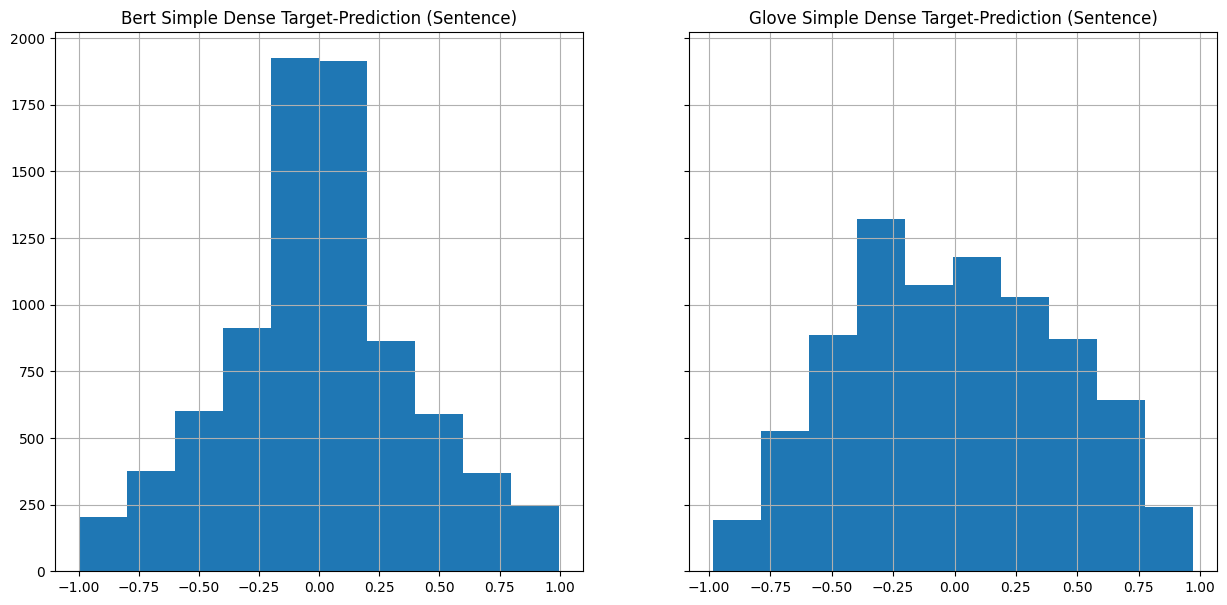

In [11]:
# bert_test_df['diff'].hist(bins=10,title='Bert Simple Dense Target-Prediction',xlabel='Target-Prediction')


helpers.plot_test_hists(bert_test_df['diff'],glove_test_df['diff'],name_1='Bert Simple Dense Target-Prediction (Sentence)',name_2='Glove Simple Dense Target-Prediction (Sentence)')

## Experiment


We have implemented the collection of names corresponding to different racial groups that we used in class. We tested for racial bias within our models by asking our models to determine the sentiment of sentences that are identical to each other, with only the name of the subject changing. The sentence used was "My name is _____", with the blank representing any name from our list. From there we graphed the sentiments corresponding to the names on swarm plots and bar plots, grouping by race to visualize the results of the model. Finally, we tested both the variance and the coefficient of variation on the data from one of the models to get the perceived racial bias expressed between the racial groups tested. The coefficient of variation was used to give us context on the spread of the graphs along with the swarm plots, and the variance was used to quantify the inequality between the groups. As a result, the variance is labeled as the "Inequality" when it is tested on the models. We hope that by having the visual aspect of the graphs paired with the numerical representation given from the inequality metric, we will be able to accurately compare multiple different models to determine which ones are more proficient at mitigating racial bias.


### Limitations


As mentioned above, PCA is one of the first limitations that we encounter, specifically when it is used on the Bert embeddings. This causes us to be unable to make any definite claims about the use of Bert in the context of our project, as we will not be able to take advantage of the full feature space of Bert, as it has gone from 768 features to 300 features. Sentences that fall below the maximum length of the dataset need to be padded to 300 times the number of words in the longest sentence for pca_decomposition. This is a limitation that we have introduced that will remove importance at the end of longer sentences. This is because we need to 0-pad the sentences that fall below the maximum length. We found this limitation unavoidable and we cannot do anything about this importance without changing our entire process.

 Furthermore, the use of different datasets for the models trained off of single words and the models trained off of sentences causes another layer of variability that does remove some validity from our claims throughout the project. Unfortunately, it is very difficult to find a single dataset that provides sentiment for both sentences and individual words, so we have been forced to use two different datasets as we outlined above. Finally, the CNN network that we have created seems to perform slightly worse than the simple neural network that we have created. This is extremely unfortunate as it limits us from determining that any differences between the networks and the racial biases that they display in their plots are a result of the use of more context from the CNN network structure, or if the differences are just side effects of the difference in accuracy between the two models.


#### Our test criteria
We have many comparisons, each comparison will feature the BERT and GLOVE counterparts. We will not be putting up the two embeddings against each other per se, but we will instead be testing the two embeddings against the network it is made from as well as the context of the dataset that was used on it. We hope to find a combination of an embedding, network, and dataset that will mitigate bias by keeping each group equal to one another in our bar plots and have a lack of variation in the swarm plots.


Below will be researching each of the combinations we prepared and want to analyze their results to see what factors in these combinations have the greatest effect towards mitigating the bias that we tested


In [12]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Ellen', 'Lauren', 'Peggy', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Torrance', 'Darnell', 'Lamar', 'Lionel',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 
        'Lavon', 'Marcellus', 'Wardell', 'Nichelle',
        'Ebony', 'Shaniqua', 
        'Jasmine', 'Tanisha', 'Tia', 'Latoya',
        'Yolanda', 'Malika', 'Yvette'
    ],
    #Larson Edit: had to remove a number of names that were not in the embedding
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Jorge', 'Santiago',
        'Mateo',  'Alejandro', 'Samuel', 'Diego', 'Daniel', 
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    #Larson Edit: had to remove a number of names that were not in the embedding
    
    # The following list conflates religion and ethnicity, I'm aware. So do given names.
    #
    # This list was cobbled together from searching baby-name sites for common Muslim names,
    # as spelled in English. I did not ultimately distinguish whether the origin of the name
    # is Arabic or Urdu or another language.
    #
    # I'd be happy to replace it with something more authoritative, given a source.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Syed', 'Samar', 'Ahmad', 'Rayyan', 'Mariam',
        'Jana', 'Malak', 'Salma', 'Nour', 'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin'
    ]
}

result_df = pd.DataFrame()

for race,names in NAMES_BY_ETHNICITY.items():
    for name in names:
        result_df = pd.concat([result_df, pd.DataFrame({'group':[race],'text':[f'my name is {name}']})])

result_df['bert_embedding'] = gen.convert_df_to_bert_embedding(result_df)['features'] 
result_df['glove_embedding'] = gen.convert_df_multi_word_to_other_embedding(result_df)['features']

result_df['bert_embedding'] = gen.dempose_using_bert_pca(np.array([v for v in result_df['bert_embedding']]))
result_df['glove_embedding'] = gen.decompose_using_other_pca(np.array([v for v in result_df['glove_embedding']]))


Grabbing BERT Embeddings with padding to 20 characters


  0%|          | 0/1 [00:00<?, ?it/s]

Converting multi word text into Other Embedding (Glove by default)


  0%|          | 0/128 [00:00<?, ?it/s]

Removing 0 entries that did not exist in embeddings
(128, 10200)


In [13]:
result_df['bert_prediction'] = bert_simple_dense.predict(np.array([v for v in result_df['bert_embedding']]))
result_df['glove_prediction'] = bert_simple_dense.predict(np.array([v for v in result_df['glove_embedding']]))


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


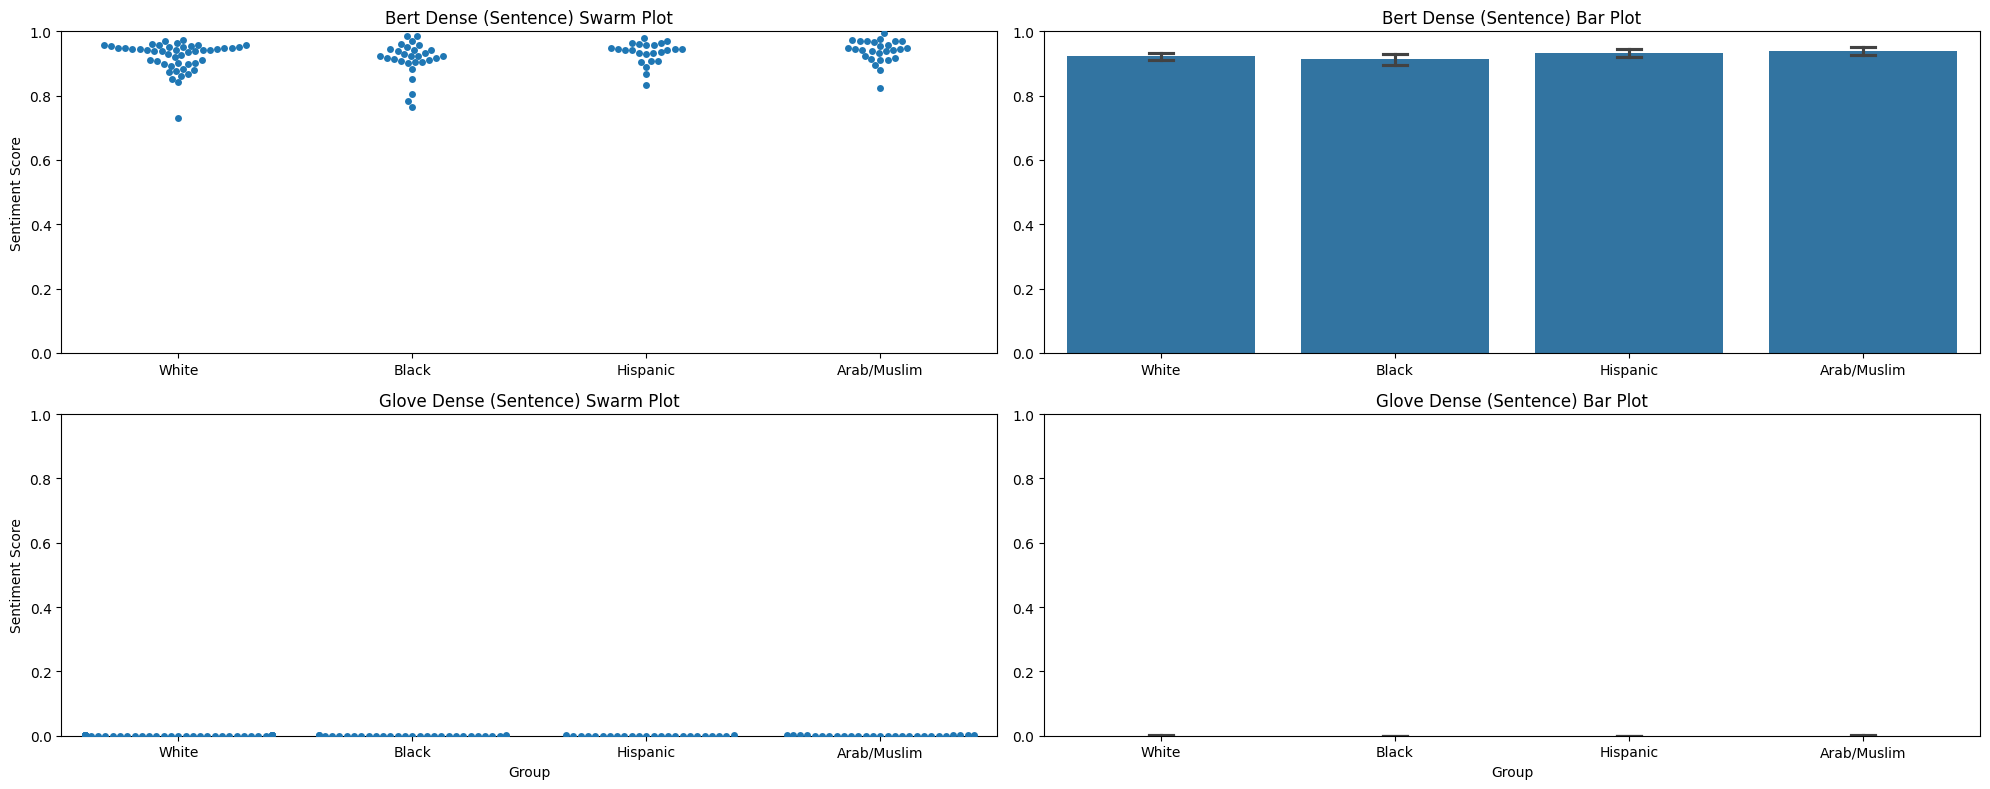

In [14]:
helpers.result_plotter(result_df,'group','bert_prediction',y2='glove_prediction',y1_name='Bert Dense (Sentence)',y2_name='Glove Dense (Sentence)')

In [15]:
helpers.print_variance_stats(result_df, title_name="Dense (Sentence) Variation statistics")

Dense (Sentence) Variation statistics
Bert Inequality: 0.036322951316833496
Bert Coefficient of Variation: 4.507191106677055
Glove Inequality: 0.0005079352995380759
Glove Coefficient of Variation: 56.72968029975891


As displayed through the swarm plots, when using a simple dense neural network and full sentences, both the plots of the Bert and Glove embeddings seems to have almost no bias based off of race. The plot of Bert seems to be ever so slighlty more biased, but the difference is negligible.

#### Logistic Regression classifier

In [16]:

bert_logistic = SGDClassifier(loss='log_loss', random_state=0, max_iter=500)
glove_logistic = SGDClassifier(loss='log_loss', random_state=0, max_iter=500)

bert_logistic.fit(bert_train_features, bert_train_labels)
glove_logistic.fit(glove_train_features, glove_train_labels)

SGDClassifier(loss='log_loss', max_iter=500, random_state=0)

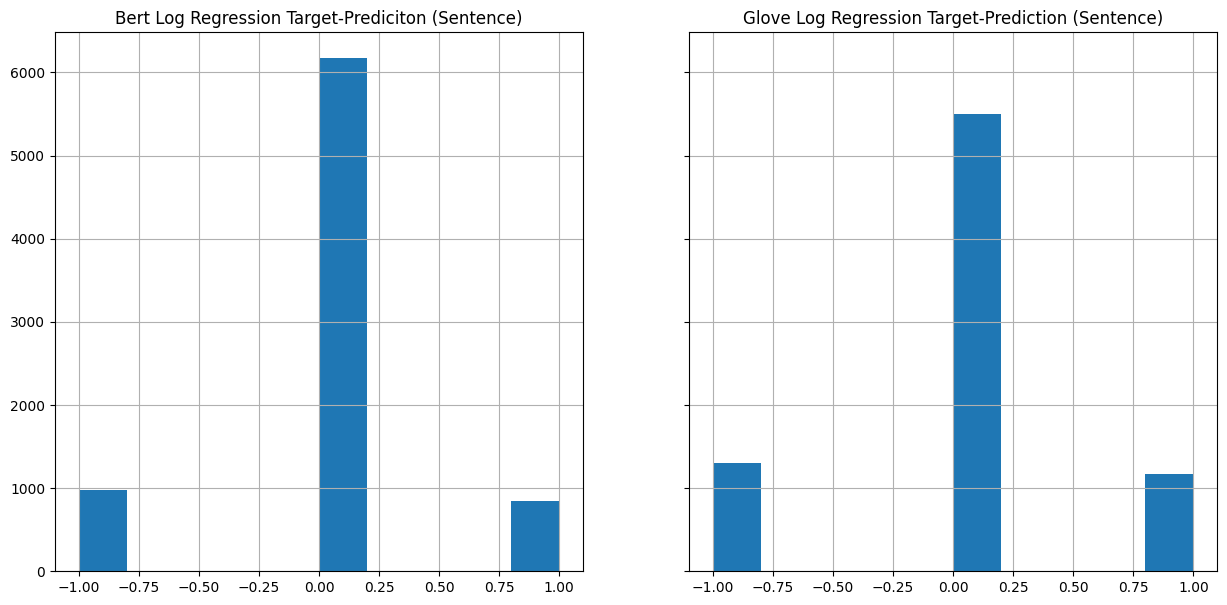

In [17]:
bert_test_df['predict'] = bert_logistic.predict(bert_test_features).flatten()  
glove_test_df['predict'] = glove_logistic.predict(glove_test_features).flatten()

bert_test_df['diff'] = bert_test_df['target'] - bert_test_df['predict']
glove_test_df['diff'] = glove_test_df['target'] - glove_test_df['predict']

helpers.plot_test_hists(bert_test_df['diff'],glove_test_df['diff'],name_1='Bert Log Regression Target-Prediciton (Sentence)',name_2='Glove Log Regression Target-Prediction (Sentence)')

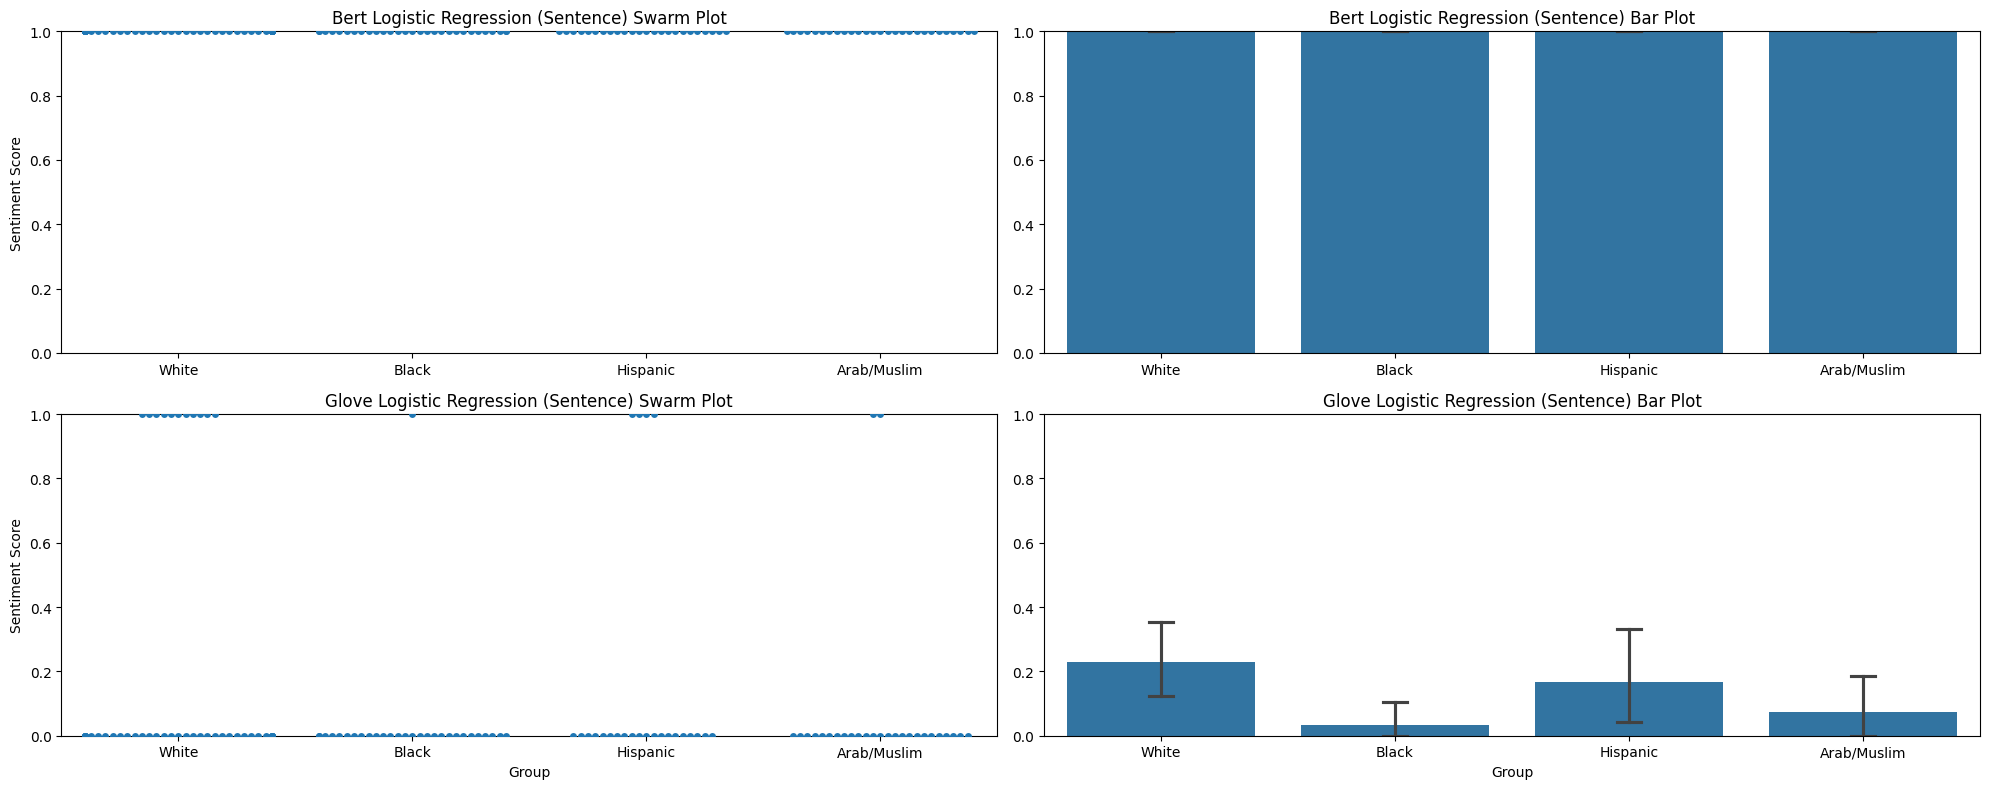

In [18]:
result_df['bert_prediction'] = bert_logistic.predict(np.array([v for v in result_df['bert_embedding']]))
result_df['glove_prediction'] = glove_logistic.predict(np.array([v for v in result_df['glove_embedding']]))

helpers.result_plotter(result_df,'group','bert_prediction',y2='glove_prediction',y1_name='Bert Logistic Regression (Sentence)',y2_name='Glove Logistic Regression (Sentence)')


In [19]:
helpers.print_variance_stats(result_df, title_name="Logistic Regression (Sentence) Variation statistics")

Logistic Regression (Sentence) Variation statistics
Bert Inequality: 0.0
Bert Coefficient of Variation: 0.0
Glove Inequality: 0.2872765006385696
Glove Coefficient of Variation: 328.1409829905177


As displayed through the swarm plots, when using a logistic regression model and full sentences, we do see a noticeable difference between the two embeddings. While the Bert plot shows almost no racial bias again, the Glove embedding shows a great deal of difference in the inherent sentiments amongst the racial groups of names. Not only does the section on black names appear much lower than any other racial group within the model, but there is a large degree of variance between all racial groups shown. We believe that this variance in sentiments provides evidence that the Glove embeddings do not mitigate bias as effectively as Bert in this context.


This originally seems to imply that it was the dense neural network framework that removed some of the racial bias from the Glove embeddings in the first swarm plots shown in the notebook. Nonetheless, we do not want to get too ahead of ourselves. Here we see that BERT is indeed better than GLOVE, but we feel we need to give GLOVE better metrics and different scenarios to really test it.


BERT has the advantage of being trained with context, so we wanted to make a CNN model to give GLOVE that context to see if it will better mitigate bias. Bert uses self-attention mechanisms to better understand the relationships between words and therefore implements context when determining the embeddings. As of now, Glove does not have these inherent context mechanisms that Bert implements. We believe that by giving the glove a form of context it will perform at a level similar to Bert, as far as mitigating racial bias.


#### Convolutional Neural Net

In [20]:
bert_cnn, bert_callbacks = helpers.generateCNN()
glove_cnn, glove_callbacks = helpers.generateCNN()

bert_result = bert_cnn.fit(bert_train_features,bert_train_labels,epochs=200,validation_data=(bert_val_features,bert_val_labels),callbacks=bert_callbacks,verbose=0)
glove_result = glove_cnn.fit(glove_train_features,glove_train_labels,epochs=200,validation_data=(glove_val_features,glove_val_labels),callbacks=glove_callbacks,verbose=0)

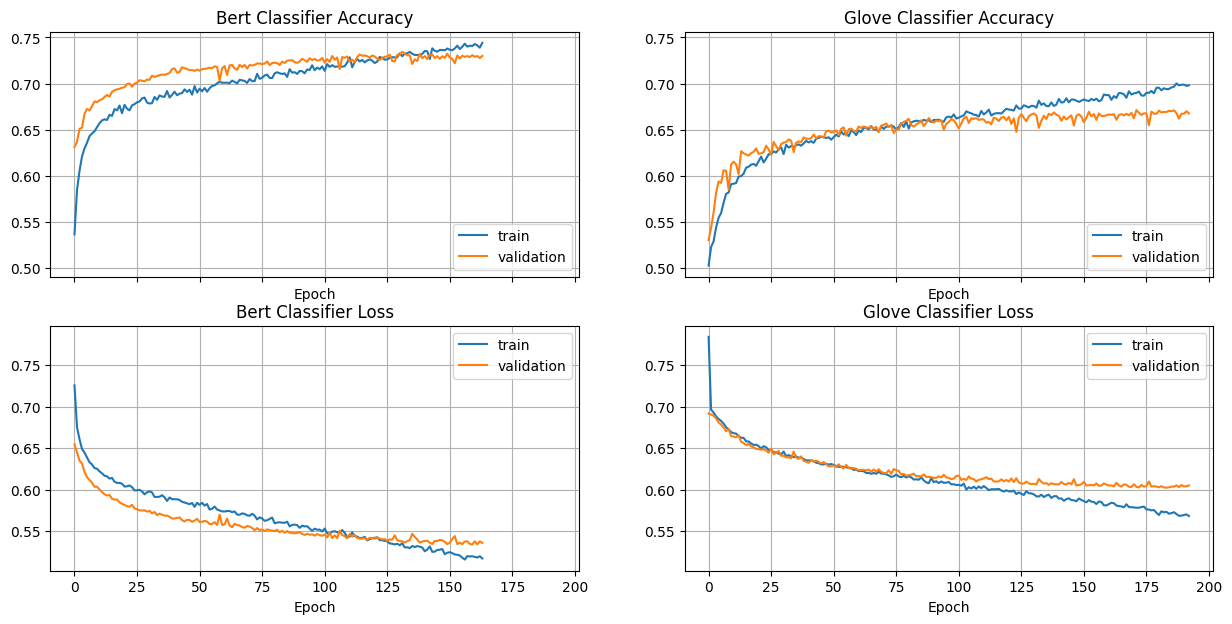

In [21]:
helpers.plot_model_stats(bert_result,glove_result)

As can be seen through the graphs, after training off of full sentences the convolutional neural network appears to converge when given both the Bert and Glove applied data. Furthermore, the graphs show no signs of overfitting within the model.

  1/250 [..............................] - ETA: 8s

249/249 [==============================] - 0s 1ms/step


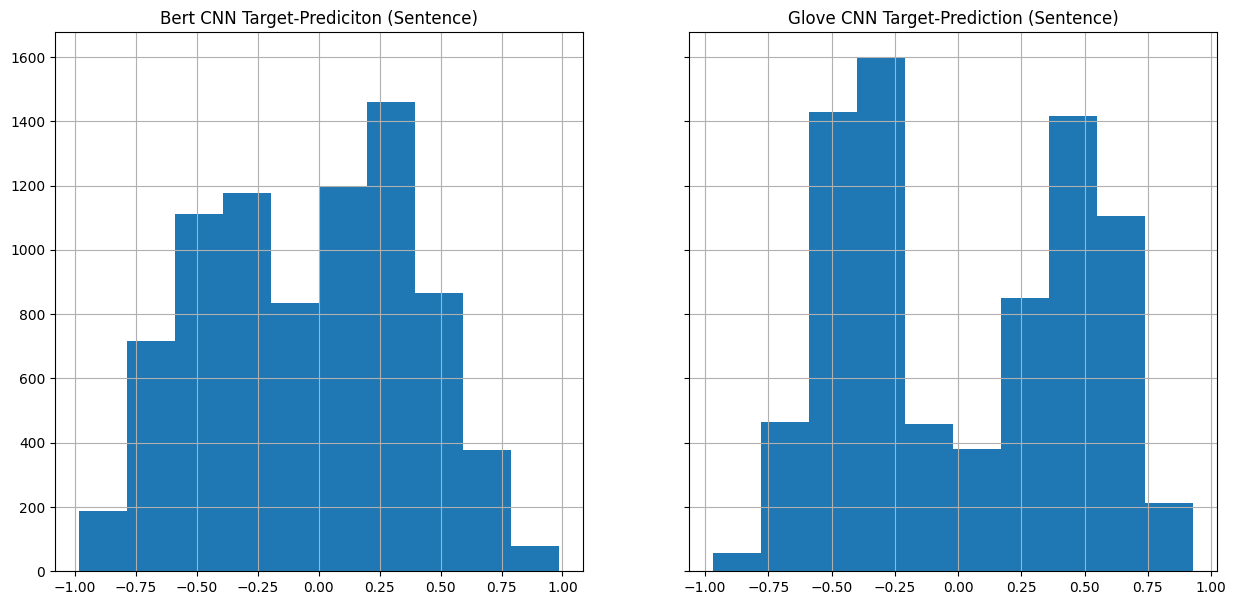

In [22]:
bert_test_df['predict'] = bert_cnn.predict(bert_test_features).flatten()  
glove_test_df['predict'] = glove_cnn.predict(glove_test_features).flatten()

bert_test_df['diff'] = bert_test_df['target'] - bert_test_df['predict']
glove_test_df['diff'] = glove_test_df['target'] - glove_test_df['predict']

helpers.plot_test_hists(bert_test_df['diff'],glove_test_df['diff'],name_1='Bert CNN Target-Prediciton (Sentence)',name_2='Glove CNN Target-Prediction (Sentence)')

4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step


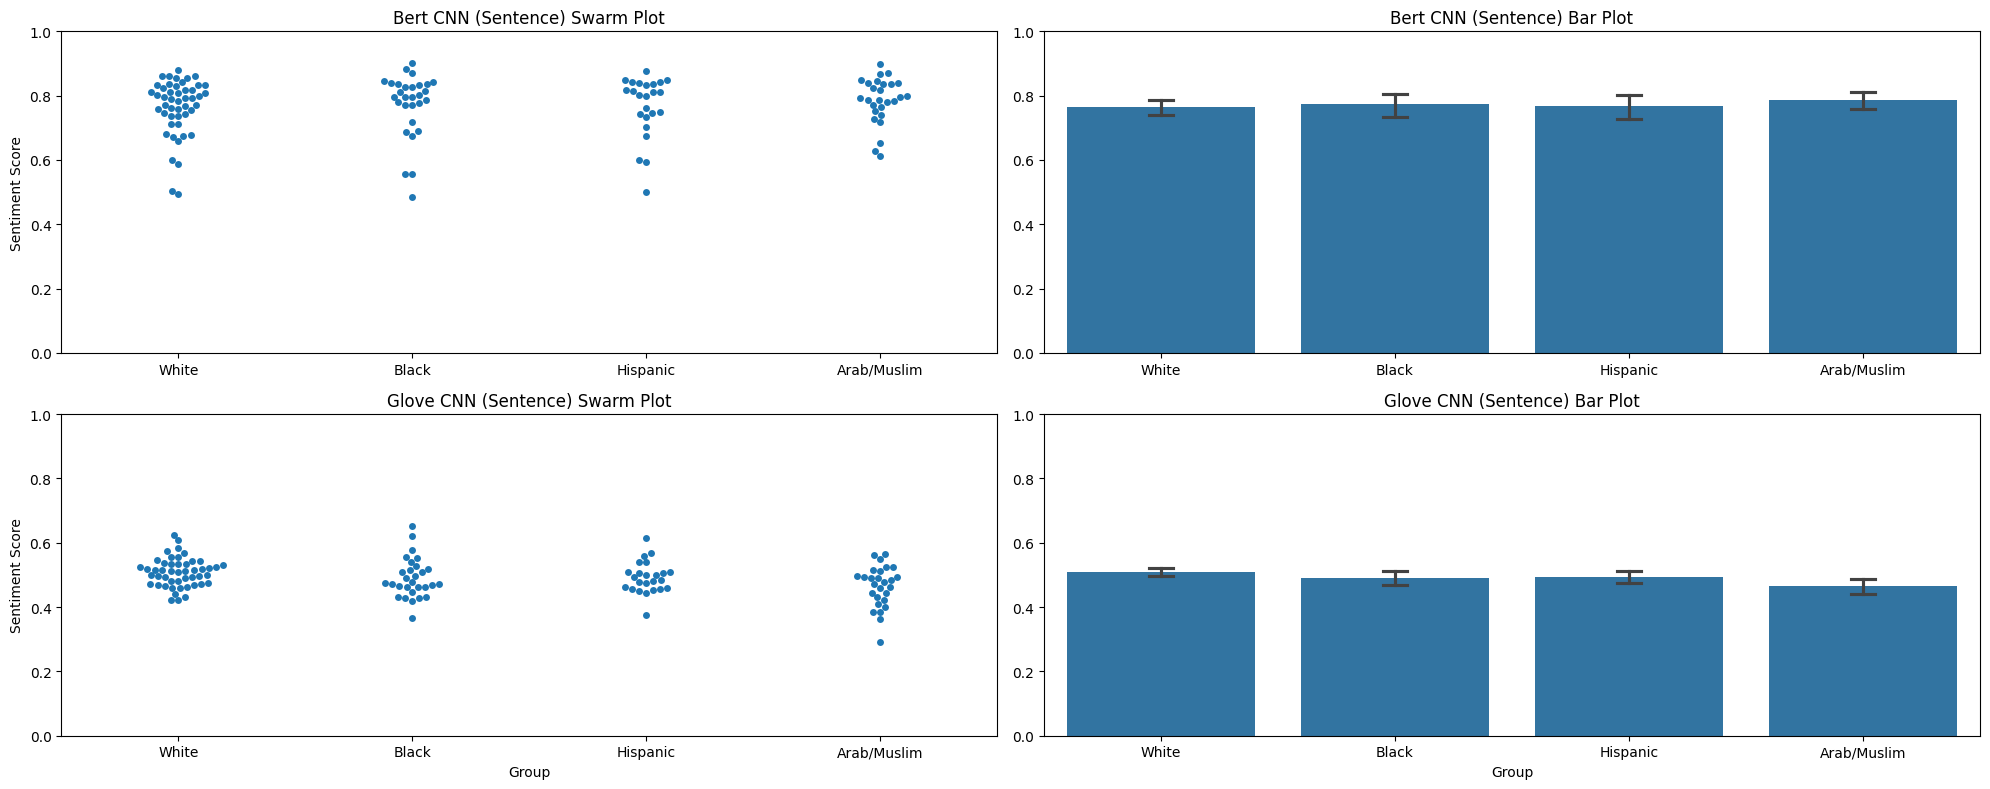

In [23]:
result_df['bert_prediction'] = bert_cnn.predict(np.array([v for v in result_df['bert_embedding']]))
result_df['glove_prediction'] = glove_cnn.predict(np.array([v for v in result_df['glove_embedding']]))

helpers.result_plotter(result_df,'group','bert_prediction',y2='glove_prediction',y1_name='Bert CNN (Sentence)',y2_name='Glove CNN (Sentence)')

In [24]:
helpers.print_variance_stats(result_df, title_name="CNN (Sentence) Variation statistics")

CNN (Sentence) Variation statistics
Bert Inequality: 0.026056349277496338
Bert Coefficient of Variation: 11.445106565952301
Glove Inequality: 0.0493009090423584
Glove Coefficient of Variation: 11.294158548116684


As displayed through the swarm plots, when using a convolutional neural network and full sentences, we see a slight amount of bias in the plots of both embeddings, but neither of them show significantly more bias than the other. Furthermore, when compared to the amount of racial bias displayed with the plot of logistic regression model, Glove is doing significantly better when given the context of the CNN. It is also producing results that are similar to Bert, which supports our hypothesis proposed at the logistic regression level, as well as our overall hypotheses that context does tend to mitigate bias. 



### Word Level Classifiers

In [25]:
word_df

,word,target
0,a+,1
1,abound,1
2,abounds,1
3,abundance,1
4,abundant,1
...,...,...
4778,zaps,0
4779,zealot,0
4780,zealous,0
4781,zealously,0


In this section we run data obtained from the sentiment lexicon dataset, and pass it through the Bert and Glove embeddings. We add respective embedding values to each data point to create the testing and training data used for all the word based prediction tasks throughout the remainder of the notebook.

In [26]:
bert_train_features, bert_test_features, bert_val_features,\
    bert_train_labels, bert_test_labels, bert_val_labels, \
    bert_train_text, bert_test_text, bert_val_text = gen.get_train_test_val_with_bert(word_df,test_size=0.2,text_col='word')

glove_train_features, glove_test_features, glove_val_features, \
    glove_train_labels, glove_test_labels, glove_val_labels, \
    glove_train_text, glove_test_text, glove_val_text = gen.get_train_test_val_with_other_embedding_single_word(word_df,test_size=0.2,text_col='word')

Grabbing BERT Embeddings with padding to 24 characters


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/6789 [00:00<?, ?it/s]

Removing 173 words that did not exist in embeddings


#### Simple Dense Net

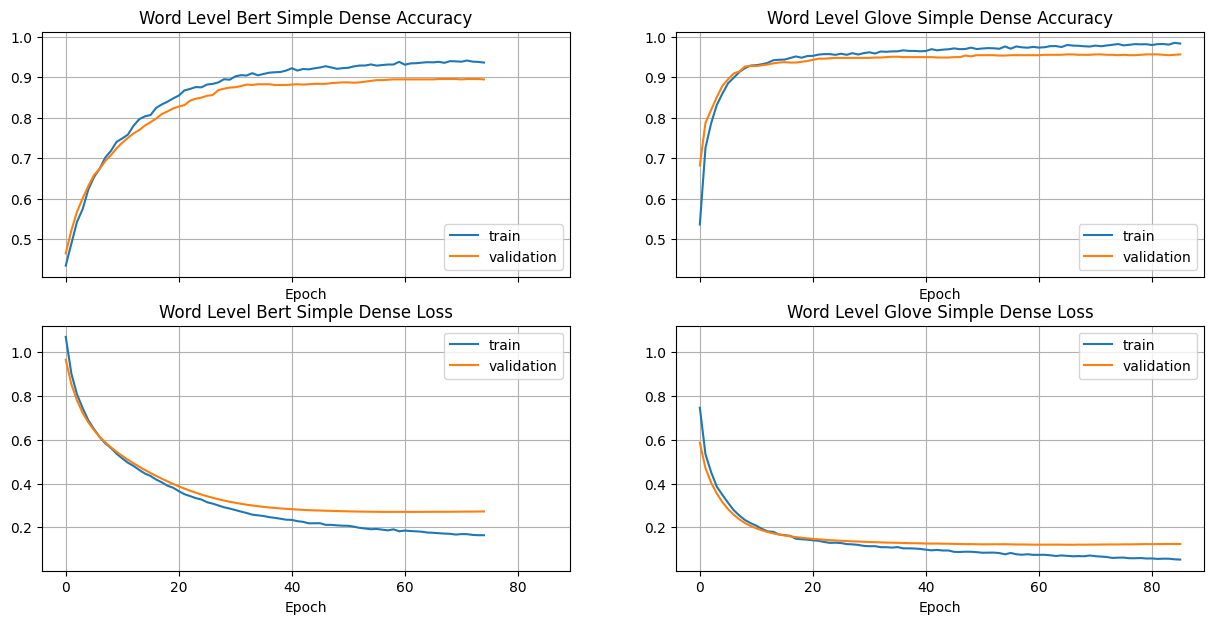

In [27]:
bert_res = bert_simple_dense.fit(bert_train_features,bert_train_labels,epochs=200,validation_data=(bert_val_features,bert_val_labels),callbacks=bert_callbacks,verbose=0)
glove_res = glove_simple_dense.fit(glove_train_features,glove_train_labels,epochs=200,validation_data=(glove_val_features,glove_val_labels),callbacks=glove_callbacks,verbose=0)
helpers.plot_model_stats(bert_res,glove_res,mdl1_name='Word Level Bert Simple Dense',mdl2_name='Word Level Glove Simple Dense')

As can be seen through the graphs, after training off of individual words the simple dense neural network appears to converge when given both the Bert and Glove applied data. Furthermore, the graphs show no signs of overfitting within the model.

In [28]:
bert_test_df = pd.DataFrame({
    'target':bert_test_labels,
    'text': bert_test_text,
    'predict': bert_simple_dense.predict(bert_test_features).flatten()
})

glove_test_df = pd.DataFrame({
    'target':glove_test_labels,
    'text': glove_test_text,
    'predict': glove_simple_dense.predict(glove_test_features).flatten()
})

bert_test_df['diff'] = bert_test_df['target'] - bert_test_df['predict']
glove_test_df['diff'] = glove_test_df['target'] - glove_test_df['predict']

 1/43 [..............................] - ETA: 1s

41/41 [==============================] - 0s 1ms/step


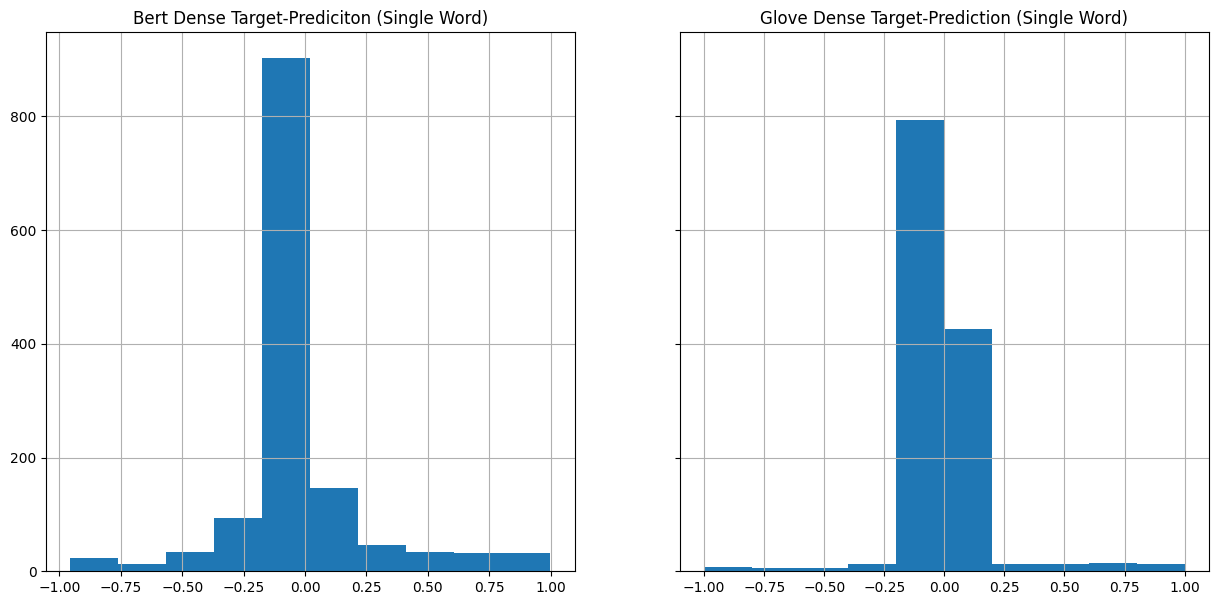

In [29]:
helpers.plot_test_hists(bert_test_df['diff'],glove_test_df['diff'],name_1='Bert Dense Target-Prediciton (Single Word)',name_2='Glove Dense Target-Prediction (Single Word)')

In [30]:
def get_predictions_for_single_words(model,res_df,text_col='text',embed_func=gen.convert_word_to_other_embedding):
    predict = []
    for sent in res_df[text_col]:
        word_sents = []
        for word in sent.split(" "):
            embed = np.array(embed_func(word))
            
            sent = model.predict(embed.reshape(-1,300))
            word_sents.append(sent)
        predict.append(np.mean(word_sents))
    return predict

result_df['glove_prediction'] = get_predictions_for_single_words(glove_simple_dense,result_df,embed_func=gen.convert_word_to_other_embedding)
result_df['bert_prediction'] = get_predictions_for_single_words(bert_simple_dense,result_df,embed_func=gen.convert_word_to_bert_embedding)


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 36ms/step


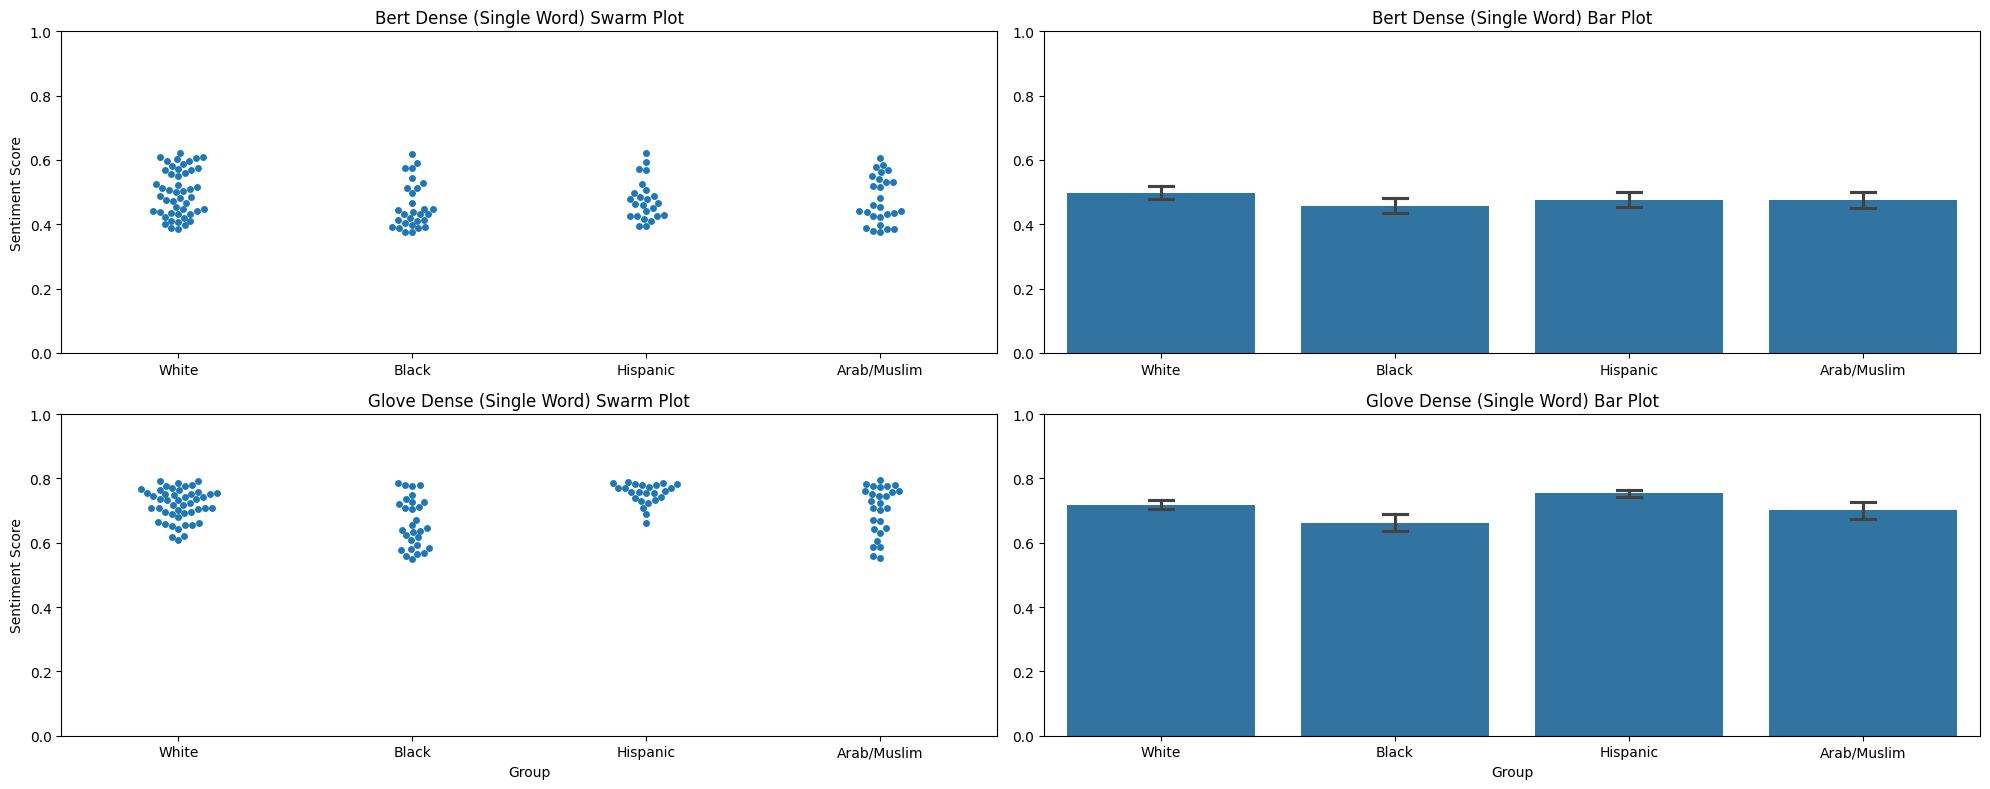

In [31]:
helpers.result_plotter(result_df,'group','bert_prediction',y2='glove_prediction',y1_name='Bert Dense (Single Word)',y2_name='Glove Dense (Single Word)')

In [32]:
helpers.print_variance_stats(result_df, title_name="Dense (Word) Variation statistics")

Dense (Word) Variation statistics
Bert Inequality: 0.043516188859939575
Bert Coefficient of Variation: 14.539322257041931
Glove Inequality: 0.1089245080947876
Glove Coefficient of Variation: 8.332232385873795


As displayed through the swarm plots, when using a simple neural network and single words, we see a slight amount of bias in the plots of both embeddings, but neither of them shows significantly more bias than the other, and both of the plots show relatively small amounts of bias. Nonetheless, the models trained off of single words do seem to show more bias within the plots than the counterparts with the same parameters that were trained off of sentences. Taking the sentiment of a single word across each word in the sentence and taking the average of those words across the sentence was how this experiment was conducted and might not be the optimal way of coalescing the sentiment of individual words into a sentence-level score.


This further promotes the theory that it is the neural network framework that is helping to mitigate a great deal of the biases for these embeddings, and it also brings forth the idea that it is possibly the attention to the context within the frameworks that is the source of said mitigation.


#### Logistic Regression Classifier

In [33]:
bert_logistic.fit(bert_train_features, bert_train_labels)
glove_logistic.fit(glove_train_features, glove_train_labels)

SGDClassifier(loss='log_loss', max_iter=500, random_state=0)

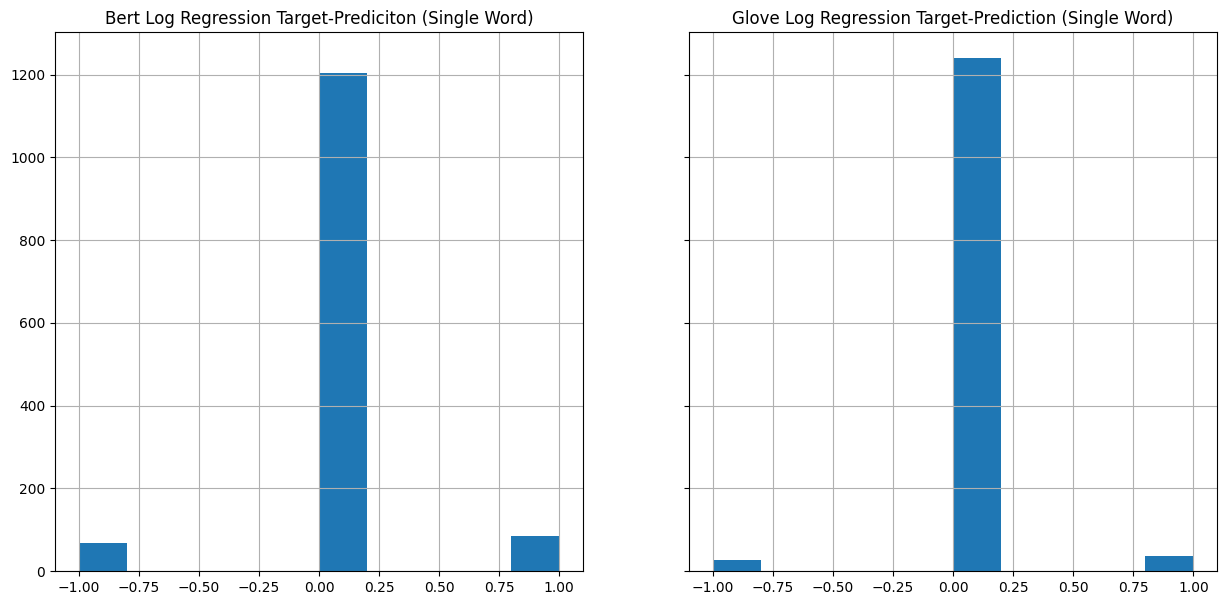

In [34]:
bert_test_df['predict'] = bert_logistic.predict(bert_test_features).flatten()  
glove_test_df['predict'] = glove_logistic.predict(glove_test_features).flatten()

bert_test_df['diff'] = bert_test_df['target'] - bert_test_df['predict']
glove_test_df['diff'] = glove_test_df['target'] - glove_test_df['predict']

helpers.plot_test_hists(bert_test_df['diff'],glove_test_df['diff'],name_1='Bert Log Regression Target-Prediciton (Single Word)',name_2='Glove Log Regression Target-Prediction (Single Word)')

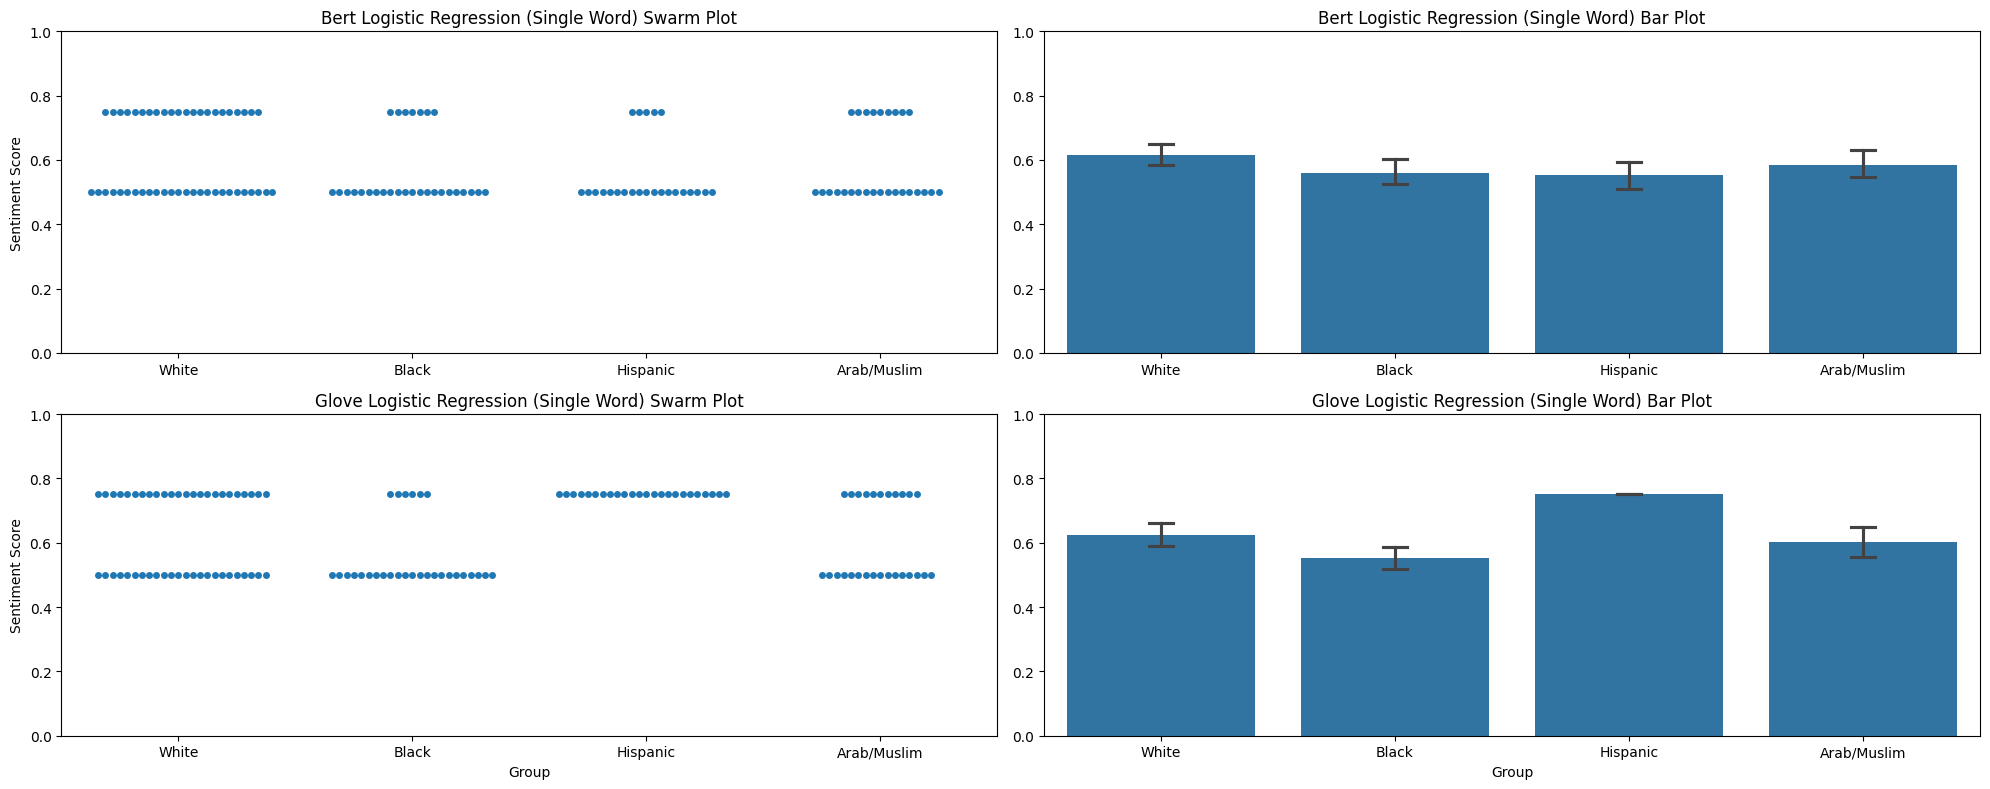

In [35]:
result_df['glove_prediction'] = get_predictions_for_single_words(glove_logistic,result_df,embed_func=gen.convert_word_to_other_embedding)
result_df['bert_prediction'] = get_predictions_for_single_words(bert_logistic,result_df,embed_func=gen.convert_word_to_bert_embedding)

helpers.result_plotter(result_df,'group','bert_prediction',y2='glove_prediction',y1_name='Bert Logistic Regression (Single Word)',y2_name='Glove Logistic Regression (Single Word)')

In [36]:
helpers.print_variance_stats(result_df, title_name="Logistic Regression (Word) Variation statistics")

Logistic Regression (Word) Variation statistics
Bert Inequality: 0.08548850574712652
Bert Coefficient of Variation: 19.821519897818753
Glove Inequality: 0.23571200510855683
Glove Coefficient of Variation: 14.922639232561307


As displayed through the swarm plots, when using a logistic regression model and a single-word dataset, we see a notable amount of bias (through the inequality of sentiment amongst racial categories) in both embeddings. The plots of the Bert and Glove embeddings do show similar amounts of bias, but the plot of Bert specifically shows much less bias than its sentence-trained counterpart. As a result, the different racial groups displayed here are not presented to have an equal sentiment with Bert or Glove.


This further promotes the hypothesis that the context seems to play a large role in the mitigation of bias seen in the models. Compared to the logistic regression model that was given whole sentences to work with, the Bert embeddings that are given the dataset of individual words showed much higher levels of racial bias, and similar to the racial bias of the graph of the Glove embeddings put in the same context. This similarity further contrasts the relationship between the two embeddings seen when fed the dataset of full sentences. When given the dataset of sentences, the plot of the Bert embeddings displayed very little bias and the Glove embeddings displayed a great deal of bias. When given the dataset of individual words, both plots of the embeddings had a fair deal of bias. This supports the hypotheses on the importance of context by showing how, when the context of the sentences is removed from the embeddings, Bert is unable to use the full extent of its context attention properties and is effectively impaired to display a level of bias similar to the plot of the Glove embeddings.


#### Convolutional Neural Net

In [37]:
bert_result = bert_cnn.fit(bert_train_features,bert_train_labels,epochs=200,validation_data=(bert_val_features,bert_val_labels),callbacks=bert_callbacks,verbose=0)
glove_result = glove_cnn.fit(glove_train_features,glove_train_labels,epochs=200,validation_data=(glove_val_features,glove_val_labels),callbacks=glove_callbacks,verbose=0)

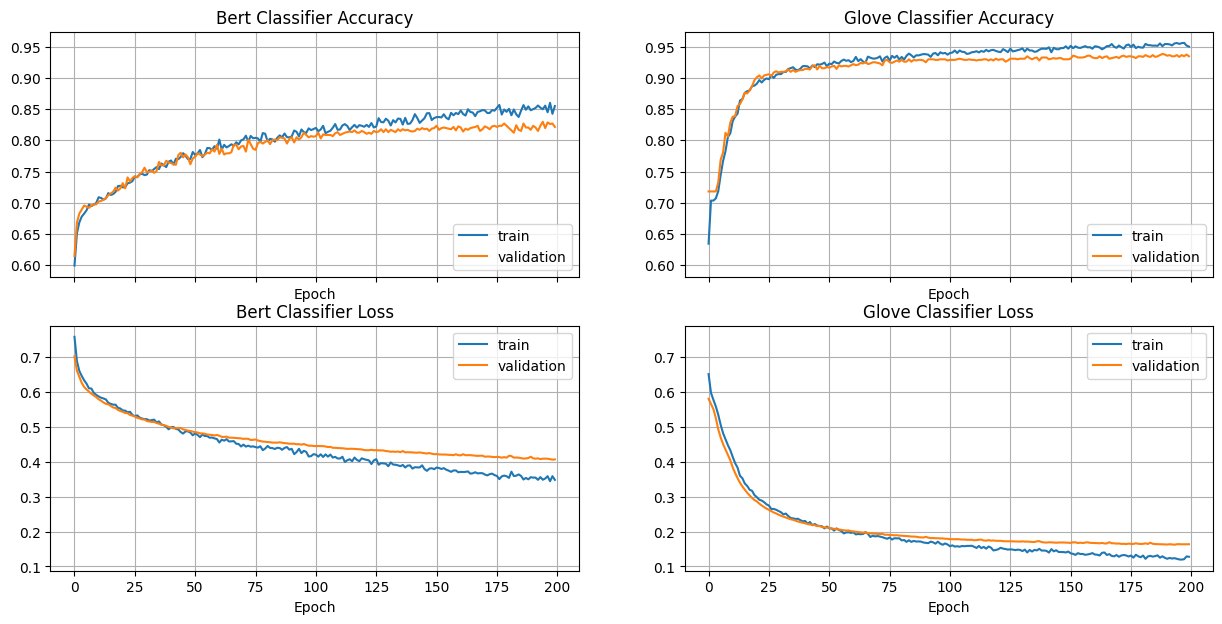

In [38]:
helpers.plot_model_stats(bert_result,glove_result)

As can be seen through the graphs, after training off of individual words the convolutional neural network appears to converge when given both the Bert and Glove applied data. Furthermore, the graphs show no signs of overfitting within the model.

41/41 [==============================] - 0s 1ms/step


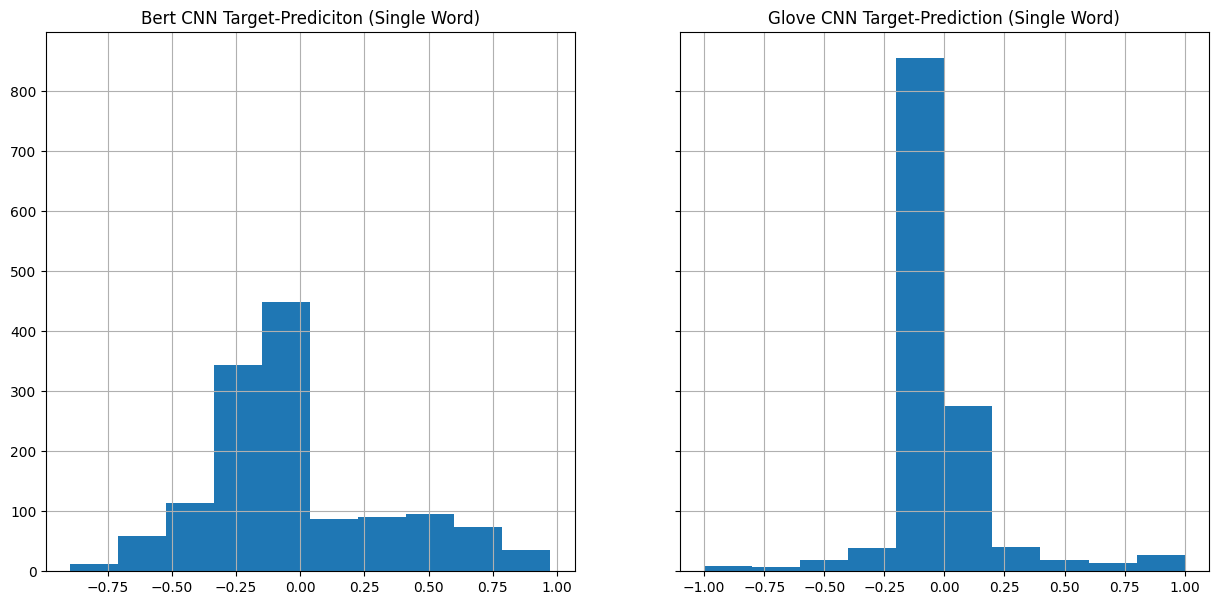

In [39]:
bert_test_df['predict'] = bert_cnn.predict(bert_test_features).flatten()  
glove_test_df['predict'] = glove_cnn.predict(glove_test_features).flatten()

bert_test_df['diff'] = bert_test_df['target'] - bert_test_df['predict']
glove_test_df['diff'] = glove_test_df['target'] - glove_test_df['predict']

helpers.plot_test_hists(bert_test_df['diff'],glove_test_df['diff'],name_1='Bert CNN Target-Prediciton (Single Word)',name_2='Glove CNN Target-Prediction (Single Word)')

1/1 [==============================] - 0s 24ms/step


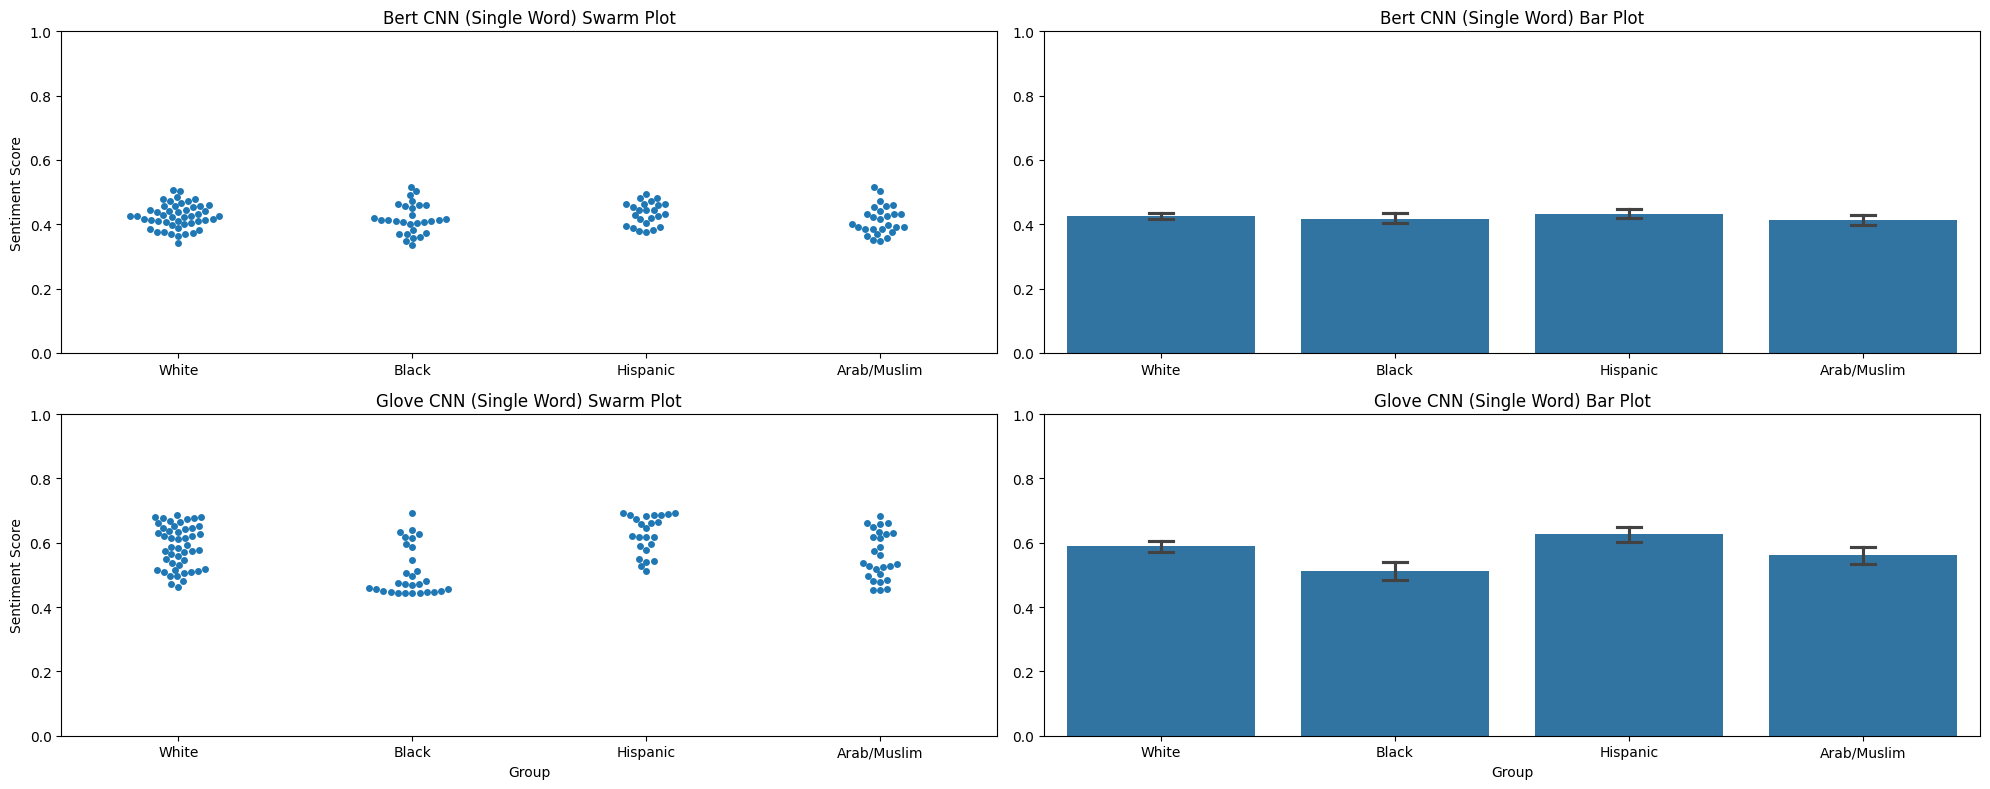

In [40]:
result_df['glove_prediction'] = get_predictions_for_single_words(glove_cnn,result_df,embed_func=gen.convert_word_to_other_embedding)
result_df['bert_prediction'] = get_predictions_for_single_words(bert_cnn,result_df,embed_func=gen.convert_word_to_bert_embedding)

helpers.result_plotter(result_df,'group','bert_prediction',y2='glove_prediction',y1_name='Bert CNN (Single Word)',y2_name='Glove CNN (Single Word)')

In [41]:
helpers.print_variance_stats(result_df, title_name="CNN (Word) Variation statistics")

CNN (Word) Variation statistics
Bert Inequality: 0.027632415294647217
Bert Coefficient of Variation: 9.777578711509705
Glove Inequality: 0.1432703137397766
Glove Coefficient of Variation: 12.232162803411484


As displayed through the swarm plots, when using a convolutional neural network and single words, we see a small amount of bias in the Bert embeddings, but a slightly higher amount of racial bias in the Glove embeddings. This higher amount of racial bias in the Glove embeddings does make it clear that for the Glove embeddings, the single-word trained models have slightly more bias than their sentence-trained counterparts.

This further promotes the theory that it is the neural network framework that is helping to mitigate a great deal of the biases for these embeddings, and it also supports the idea that the attention to context within the frameworks  is the source of the mitigation of racial biases.

## Conclusion


In response to our first hypothesis, we seem to have been overwhelmingly correct in that, throughout all different predictive modeling structures, and regardless if the model was trained off of a single word dataset or a sentence-based dataset, the models made with the Bert embeddings seem to mitigate bias more effectively than its Glove embedding counterparts. The only exception to this is when both embeddings are trained off of sentence-based data and used with the simple neural network framework. In this case, the Glove embeddings do show less bias in the plots and have a lower inequality score than the Bert embeddings, but this happened due to the fact that every name value in this specific Glove model returned a sentiment of zero or almost zero. After much consideration, this does seem to be an anomaly in our data that we are not able to explain. Adding to the unusual nature of this specific case, the coefficient of variation is very high considering there is almost no perceived variation in the groups on the swarm plot or the bar plot. On an earlier iteration of the notebook, we received a plot for this specific Glove model that returned data that was much more conducive with our predictions of Glove displaying less bias than Bert(see plot `(a)`). We are not sure why this changed later.


Regarding the second hypothesis, we saw multiple instances of the existence of higher attention to context being related to more of a mitigation of racial bias, and as a result, it appears that our hypothesis has been proven correct. The primary way that we see this is through the fact that the Bert embedding-trained models consistently outperform the GLoVe-trained models when given sentence-based data, as we saw in the first hypothesis. This promotes our hypothesis through the fact that Bert inherently takes into account the content of the words it is given when being fed sentence data and the Glove embeddings do not. Although it does not necessarily prove that context has a large role in the mitigation of racial bias, our results do help support the claim.


Furthermore, when looking purely at the models used with the Glove embeddings, which do not inherently include any attention to bias, we see that the use of a CNN greatly improves the level of bias mitigation that the Glove-based model presented in their plots. This can be seen clearly when comparing the Glove model using linear regression and sentence data (see plot `(b)`), and the Glove model using a CNN and sentence data(see plot `(c)`). Both models are given sentence data, so there is context that can be used when the models are training, but the model using logistic regression shows a much worse inequality score as well as visually perceived inequality than its Bert counterpart. On the other hand, the CNN that uses the Glove embeddings seems to display much lower levels of bias by the same metric than the logistic regression model, and it even shows similar levels of bias in the plots as its Bert counterpart. This suggests that it is the convolutional framework, that includes an aspect of attention to context, which causes the improvement in the Glove embedding model, further supporting our hypothesis on the importance of context.


Finally, when we look at every instance of a Bert embedding-based model that is given the sentence-based dataset compared to every instance of a Bert embedding-based model that is given a single word-based dataset, the model that is fed the sentences performs better for every different prediction network that it is given. This firmly supports our hypothesis on the importance of context, but it should be noted that despite the fact that the Bert-based models displayed less racial bias when trained on single word-based data, the difference was not near as severe as we expected it to be, which speaks to the power of Bert embeddings in sentiment analysis tasks.


In conclusion, in every testing situation, we gave to the Bert embedding-based models, it outperformed our expectations and consistently performed better than Glove-based models (with the exception of the Glove anomaly). This led us to the hypothesis that it is most likely the word embeddings themselves that are the most prominent feature in machine learning models when it comes to mitigating racial bias. This research question was not one we got to focus on in this notebook, but if we were to test based on this in the future we would compare models based on Bert embeddings to other models with context-based attention mechanisms, such as other transformers. Nonetheless, the influence of the word embeddings has become clear through our test and it would be extremely interesting to investigate in the future.


#### Conclusion Limitations


There were some limitations throughout the research process, and the most prevalent of these is the fact that we only had one instance of fair comparison between the Bert embeddings and the Glove embeddings, which gave them an equal chance. This instance was when both embeddings were given a dataset of sentences and applied to a CNN. In hindsight, it would have been ideal to have more types of context-based embeddings and context-based modelings to compare with the Bert embeddings. This research has proven to us that Bert is incredible at mitigating bias, so comparing Bert with something that could rival it would allow us to pursue what is the cause of racial bias in context-based embeddings. Unfortunately, we did not know for certain that Bert would perform this well at the beginning of this research project, so we could not make those adjustments beforehand. There were other instances of limitations within the execution of the tests, which were discussed earlier in the notebook, but these are more relevant to the details of the tests and not the overall conclusions.


### Plot (a)

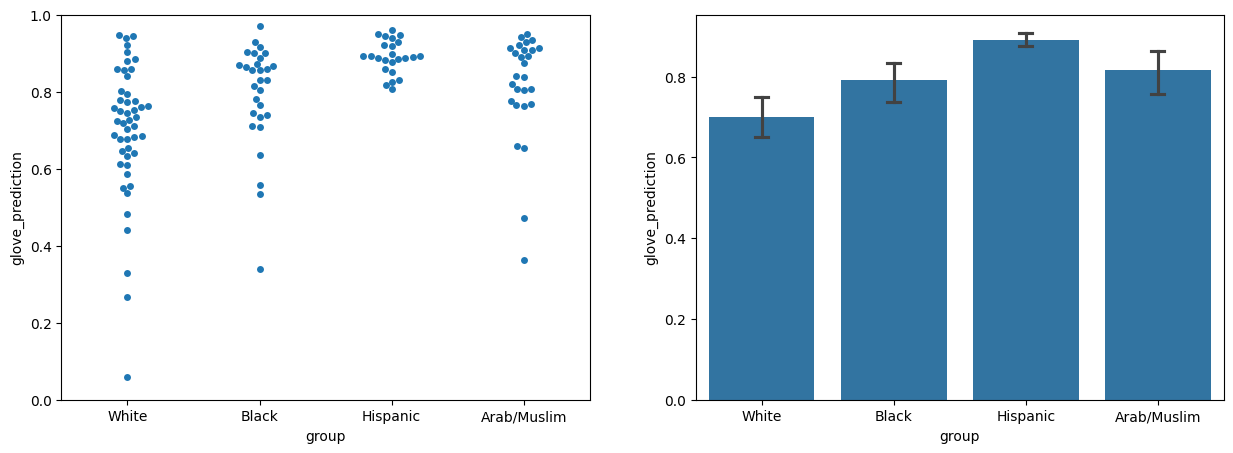

### Plot (b)


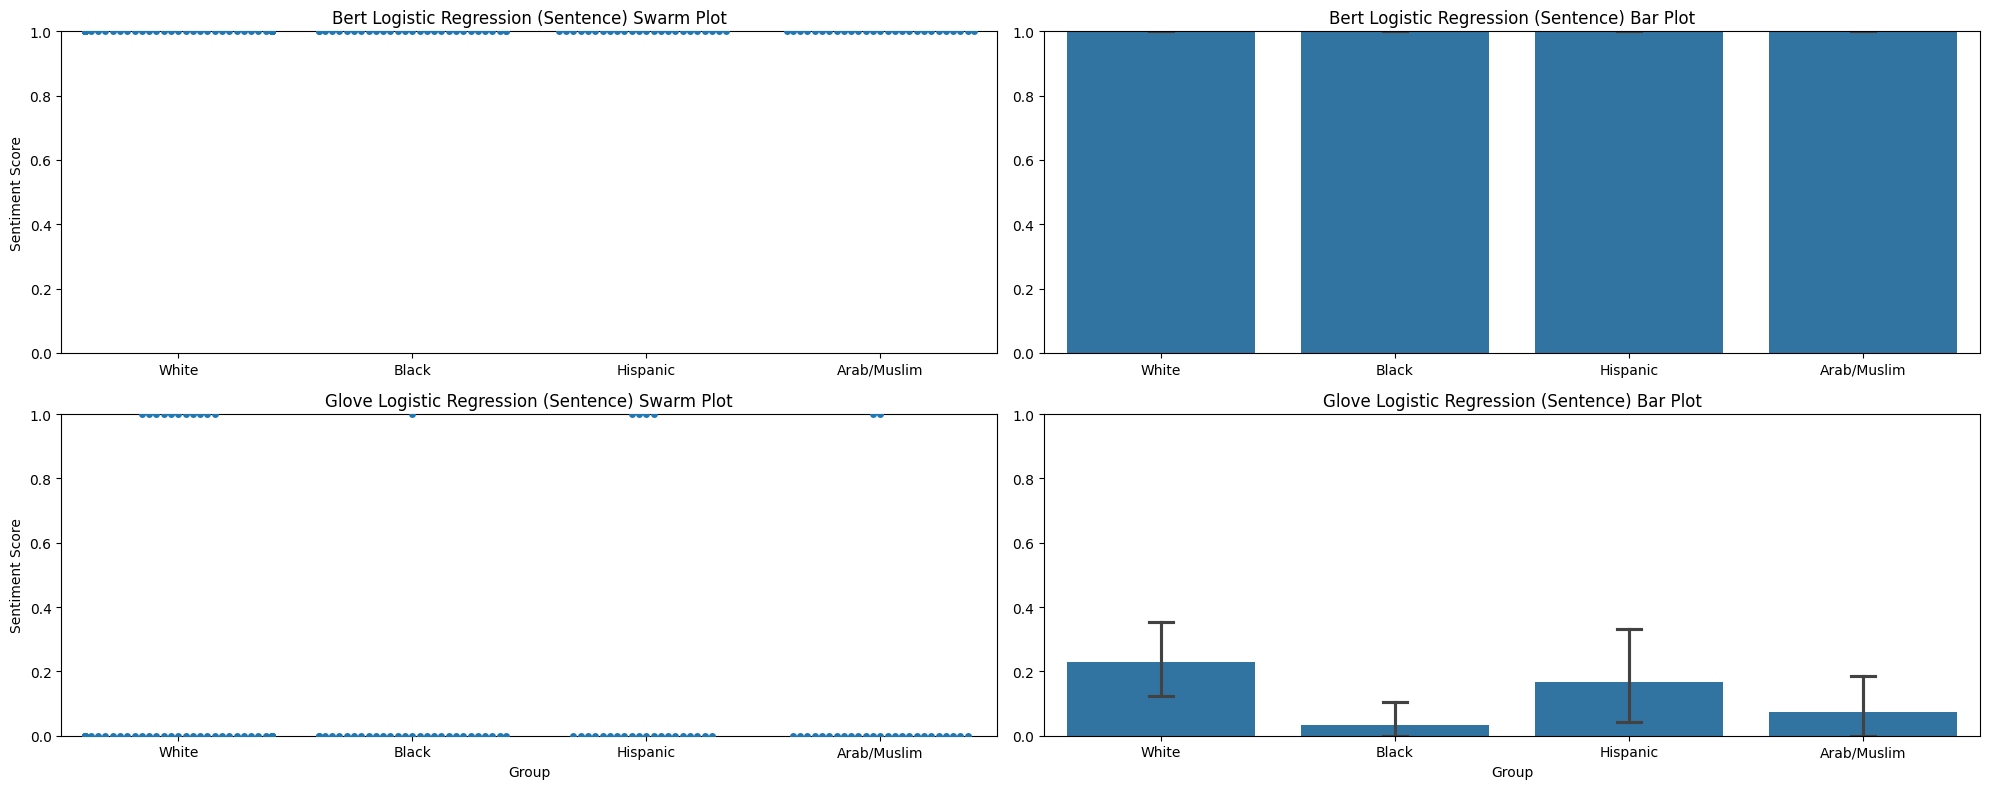

### Plot (c)


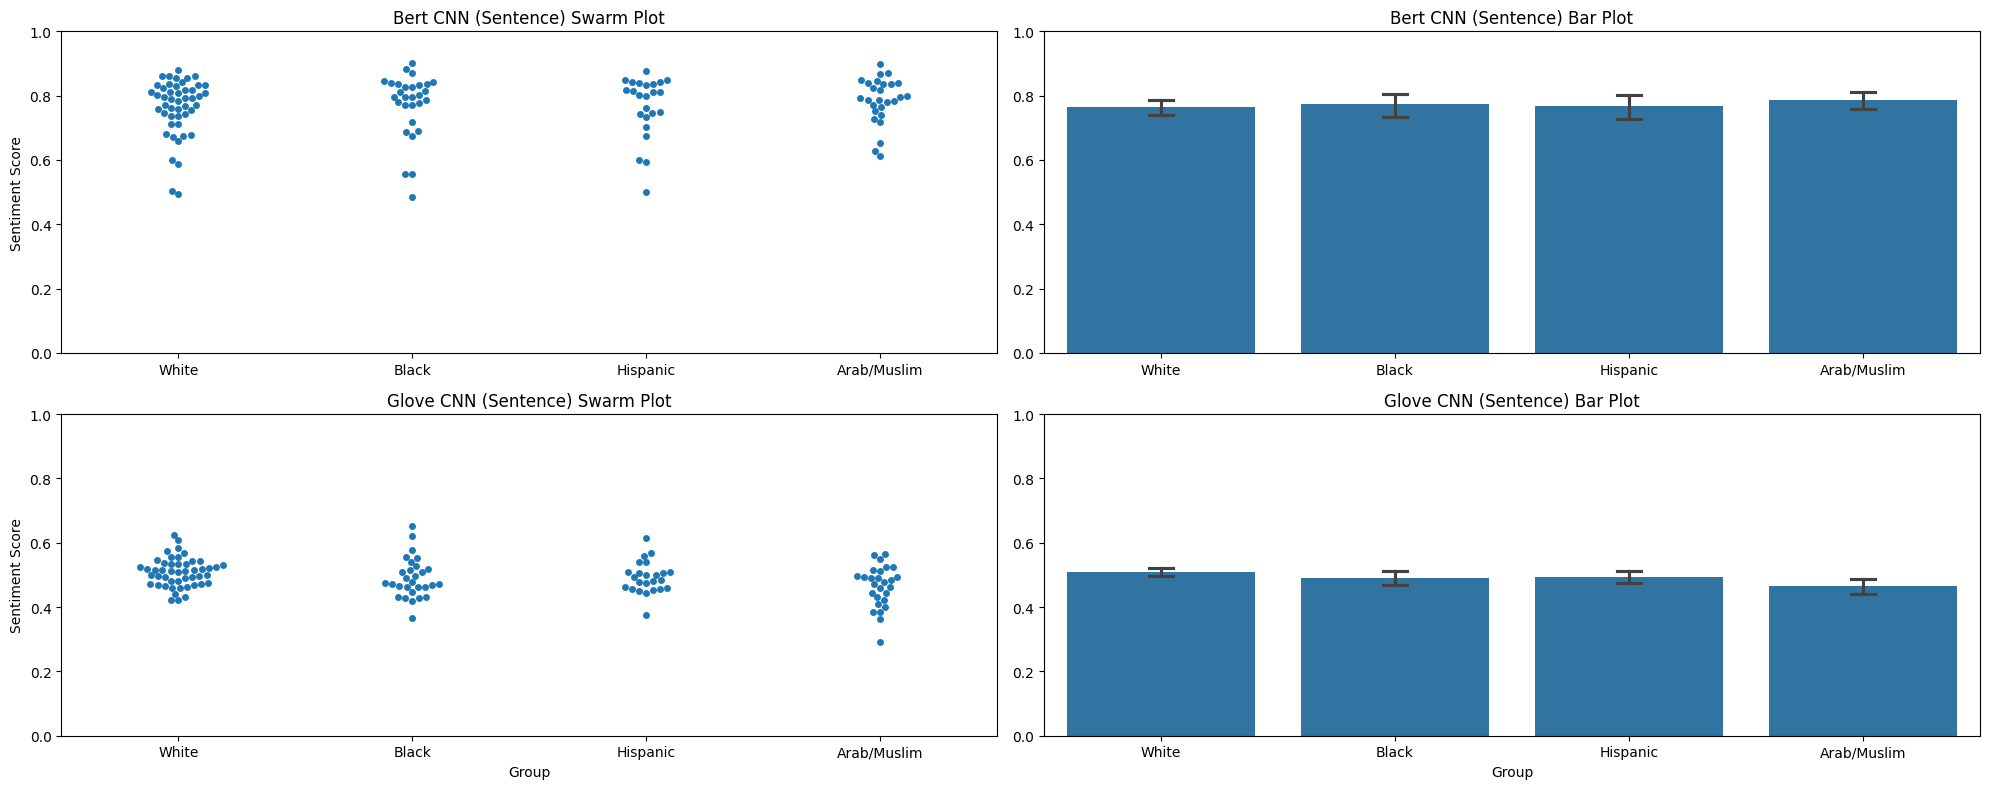

### Potential Interested Journals and Conferences

**NeurIPS** This conference is a very widespread conference about the development of the "neural information system" which will definetly include topics like Natural Langauge procesing. It is a fostering ground for people to publish their findings as the conference is a platform for all researchers even students to showcase their research. We feel like our research into the Contextual word embedding of BERT to mitigate bias is a paper that would fit right in. In researching which conferences would be interested we came across the proceedings of NeurIPS 2019 (https://proceedings.neurips.cc/paper_files/paper/2019) where a group wanted to see if they can mitigate biases at the "word representation level" in which they also looked into BERT! So we think our research falls right into line with a paper that was already discussed at this conference.

**EMNLP** The Empirical Methods in Natural Language Processing conference is a premier conference specifically focusing on NLP. This conference we think would be of great interest to our topics because bias mititgation is a very popular topic. This year's 2023 proceedings (https://aclanthology.org/volumes/2023.emnlp-main/) I found over 45 different papers relating to the topic of bias, finding bias, mitigating bias, and debiasing techniques. This would be another perfect venue to learn about the biases found in these word embeddings.